In [1]:
import numpy as np     
import pandas as pd                     
import matplotlib.pyplot as plt

from pykat import finesse                 
from pykat.commands import *               
from pykat.optics.maps import * 
from pykat.parallel import parakat

%config InlineBackend.figure_format='svg'
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## Content:
This file is about calculating the loss and purity of HG33 and LG22 modes with increasing astigmatism added to the maps.

### Note:
1.  The maps are generated in file 'Maps with increasingly astigmatism content(Z22).ipynb'
2.  To see increasing astigmatism by setting different Rcx and Rcy, ref file 'Increasing astigmatism using astigmatic cavity eigenmodes.ipynb'

In [2]:
#clipping loss of 1ppm
katHG33 = pykat.finesse.kat()
katHG33.verbose=False
katHG33.parse("""
l laser 1 0 0 n0
s s0 1 n0 nmod1

mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1

m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 3.8 n3 n4

#higher order mode TEM33
tem laser 0 0 0.0 0.0
tem laser 3 3 1.0 0.0

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -2679.93
attr ETM Rc 2679.93
#Rc=2679.93 when clipping loss is 1ppm for HG33

pd1 pdh 60M 0 n1

set err pdh re
lock clock $err 1 1n
put* ETM phi $clock


maxtem 8

""")

In [3]:
#clipping loss of 1ppm
katLG22 = pykat.finesse.kat()
katLG22.verbose=False
katLG22.parse("""

l laser 1 0 0 n0
#gauss g1 laser n0 1m 0
maxtem 8

s s0 1 n0 nmod1
mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1
m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 26.5 n3 n4

#higher order mode LG22
tem laser 0 0 0 0
tem laser 6 0 0.234375 0
tem laser 5 1 0.15625 -90
tem laser 4 2 0.015625 0
tem laser 3 3 0.1875 -90
tem laser 2 4 0.015625 180
tem laser 1 5 0.15625 -90
tem laser 0 6 0.234375 180

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -2789.58
attr ETM Rc 2789.58
#Rc=2789.58 when clipping loss is 1ppm for LG22

pd1 pdh 60M 0 n1
set err pdh re
lock clock $err 1 1n
put* ETM phi $clock

""")

In [17]:
# to create a prefect LG22 basis to be projected into
LG22nomap = katLG22.deepcopy()  
LG22nomap.parse("""
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        """)
outLGnomap=LG22nomap.run()
beamLGnomap=outLGnomap["ccd"]


# reference power when applying zero map
# null map of size 1133*1133: "Z22order0phasemap1133" because the base map is 1133*1133
LG22zeromap = katLG22.deepcopy()
LG22zeromap.parse("""
        map ETM Znmmaps/Z22order0phasemap1133.txt
        pd Pcirc n3
        """)
LG22zeromap.noxaxis = True
outLGzeromap=LG22zeromap.run()
powerzeromap=outLGzeromap["Pcirc"]


pkLG=parakat()
for i in range(7):
    LG22beam = katLG22.deepcopy()
    LG22beam.parse(f"""
            map ETM Z22maps/Z22map{i}.txt
            beam ccd 0 n3
            xaxis ccd x lin -7 7 200
            x2axis ccd y lin -7 7 200
            yaxis abs:deg
            pd Pcirc n3
            """)
    pkLG.run(LG22beam)
outLGmap = pkLG.getResults()


# projecting the measureed beam profile to LG22 basis to get the purity
# and use the purity and measured power to get the loss
LGpurity=[]
LGloss=[]
for i in range(7):
    beamLGmap=outLGmap[i]['ccd']
    powermap=outLGmap[i]["Pcirc"]
    a=np.real(np.sum(np.conj(beamLGmap)*beamLGnomap)*np.sum(np.conj(beamLGnomap)*beamLGmap))
    b=np.sum(np.abs(beamLGmap)**2)
    c=np.sum(np.abs(beamLGnomap)**2)
    purity=np.sqrt(a/(b*c))

    loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]
    LGpurity.append(purity)
    LGloss.append(loss)

pd.Series(LGpurity).to_pickle('pkl/Z22LG22purity.pkl')
pd.Series(LGloss).to_pickle('pkl/Z22LG22loss.pkl')

Parallel jobs: 100%|##########################################################|

In [4]:
# to create a prefect HG33 basis to be projected into
HG33nomap = katHG33.deepcopy() 
HG33nomap.parse("""
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        """)
outHGnomap=HG33nomap.run()
beamHGnomap=outHGnomap["ccd"]


#reference power when applying zero map
HG33zeromap = katHG33.deepcopy()
HG33zeromap.parse("""
        map ETM Znmmaps/Z22order0phasemap1133.txt
        pd Pcirc n3
        """)
HG33zeromap.noxaxis = True
outHGzeromap=HG33zeromap.run()
powerzeromap=outHGzeromap["Pcirc"]


pkHG=parakat()
for i in range(44):
    HG33beam = katHG33.deepcopy()
    HG33beam.parse(f"""
            map ETM Z22maps/Z22map{i}.txt
            beam ccd 0 n3
            xaxis ccd x lin -7 7 200
            x2axis ccd y lin -7 7 200
            yaxis abs:deg
            pd Pcirc n3
            """)
    pkHG.run(HG33beam)
outHGmap = pkHG.getResults()

HGpurity=[]
HGloss=[]
for i in range(44):
    beamHGmap=outHGmap[i]['ccd']
    powermap=outHGmap[i]["Pcirc"]
    a=np.real(np.sum(np.conj(beamHGmap)*beamHGnomap)*np.sum(np.conj(beamHGnomap)*beamHGmap))
    b=np.sum(np.abs(beamHGmap)**2)
    c=np.sum(np.abs(beamHGnomap)**2)
    purity=np.sqrt(a/(b*c))

    loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]
    HGpurity.append(purity)
    HGloss.append(loss)
pd.Series(HGpurity).to_pickle('pkl/Z22HG33purity1.pkl')
pd.Series(HGloss).to_pickle('pkl/Z22HG33loss1.pkl')

/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2114: UserWarning: 'KatRun2D' does not have attribute called 'katPath'
  r.katPath = kat_exec
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2345: UserWarning: 'KatRun2D' does not have attribute called 'save_output'
  r.save_output = save_output
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2362: UserWarning: 'KatRun2D' does not have attribute called 'save_input'
  r.save_input = save_kat
/opt/anaconda3/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for [Liu]: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
Parallel jobs: 100%|##########################################################|

In [6]:
# get the input laser mode and use it to fix the input laser mode in file Increasing astigmatism using astigmatic cavity eigenmodes.ipynb'
i=0
HG33beam = katHG33.deepcopy()
HG33beam.parse(f"""
        bp inputx x q n2
        map ETM Z22maps/Z22map{i}.txt
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        pd Pcirc n3
        """)
out = HG33beam.run()
out['inputx'][0][0]

/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2114: UserWarning: 'KatRun2D' does not have attribute called 'katPath'
  r.katPath = kat_exec
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2345: UserWarning: 'KatRun2D' does not have attribute called 'save_output'
  r.save_output = save_output
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2362: UserWarning: 'KatRun2D' does not have attribute called 'save_input'
  r.save_input = save_kat


(-1997.234599999995+1167.6912580562025j)

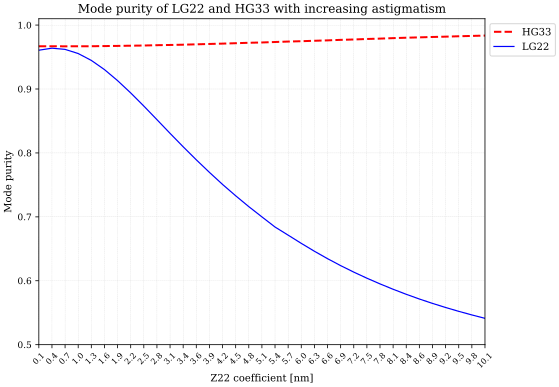

In [29]:
HG33purityZ22_array=pd.read_pickle('pkl/Z22HG33purity.pkl').values
LG22purityZ22_array=pd.read_pickle('pkl/Z22LG22purity.pkl').values

xticks=np.around(0.12+np.linspace(0,10,35), decimals=1)
#xticks=[",".join(item) for item in xticks.astype(str)]
fig,ax=plt.subplots(figsize=(8,6))
ax.plot(HG33purityZ22_array,'r--',label='HG33', linewidth=2)
ax.plot(LG22purityZ22_array,'b',label='LG22')
#ax.plot(HG00purityZnm_array,'y',label='HG00')
# ax.axhline(y=np.mean(HG33purityZ22_array),color='y', label='HG33 average')
# ax.axhline(y=np.mean(LG22purityZ22_array), color='m', label='LG22 average')
ax.set_xlabel("Z22 coefficient [nm]")
ax.set_xticks(range(35))
ax.set_xticklabels(list(xticks),rotation=45, fontsize=8)
ax.set_ylabel("Mode purity")
ax.set_title("Mode purity of LG22 and HG33 with increasing astigmatism")
ax.set_ylim(0.5,1.01)
ax.legend(loc=2,bbox_to_anchor=(1,1))
plt.show()

In [3]:
fig.savefig('../purity HG33 and LG22 astigmatism.pdf')

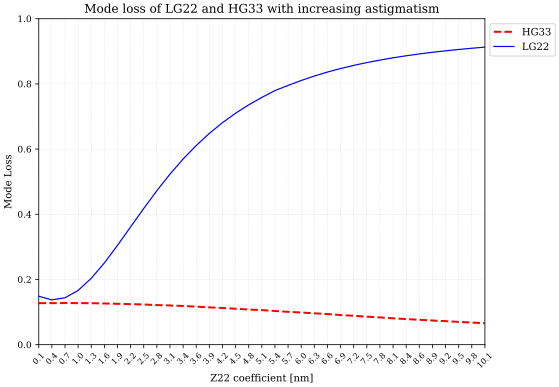

In [27]:
LG22lossZ22_array=pd.read_pickle('pkl/Z22LG22loss.pkl').values
HG33lossZ22_array=pd.read_pickle('pkl/Z22HG33loss.pkl').values

xticks=np.around(0.12+np.linspace(0,10,35), decimals=1)
#xticks=[",".join(item) for item in xticks.astype(str)]
fig,ax=plt.subplots(figsize=(8,6))
ax.plot(HG33lossZ22_array,'r--',label='HG33', linewidth=2)
ax.plot(LG22lossZ22_array,'b',label='LG22')
#ax.plot(HG00purityZnm_array,'y',label='HG00')
# ax.axhline(y=np.mean(HG33lossZ22_array),color='y', label='HG33 average')
# ax.axhline(y=np.mean(LG22lossZ22_array), color='m', label='LG22 average')
ax.set_xlabel("Z22 coefficient [nm]")
ax.set_xticks(range(35))
ax.set_xticklabels(list(xticks),rotation=45, fontsize=8)
ax.set_ylabel("Mode Loss")
ax.set_title("Mode loss of LG22 and HG33 with increasing astigmatism")
ax.set_ylim(0,1)
ax.legend(loc=2,bbox_to_anchor=(1,1))
plt.show()

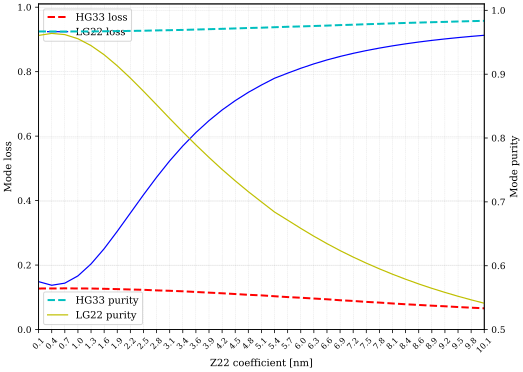

In [2]:
# put the two graphs together
LG22lossZ22_array=pd.read_pickle('pkl/Z22LG22loss.pkl').values
HG33lossZ22_array=pd.read_pickle('pkl/Z22HG33loss.pkl').values
HG33purityZ22_array=pd.read_pickle('pkl/Z22HG33purity.pkl').values
LG22purityZ22_array=pd.read_pickle('pkl/Z22LG22purity.pkl').values

xticks=np.around(0.12+np.linspace(0,10,35), decimals=1)
#xticks=[",".join(item) for item in xticks.astype(str)]
fig,ax=plt.subplots(figsize=(8,6))
ax.plot(HG33lossZ22_array,'r--',label='HG33 loss', linewidth=2)
ax.plot(LG22lossZ22_array,'b',label='LG22 loss')
#ax.plot(HG00purityZnm_array,'y',label='HG00')
# ax.axhline(y=np.mean(HG33purityZ22_array),color='y', label='HG33 average')
# ax.axhline(y=np.mean(LG22purityZ22_array), color='m', label='LG22 average')
ax.set_xlabel("Z22 coefficient [nm]")
ax.set_xticks(range(35))
ax.set_xticklabels(list(xticks),rotation=45, fontsize=8)
ax.set_ylabel("Mode loss")
#ax.set_title("Mode purity of LG22 and HG33 with increasing astigmatism")
ax.set_ylim(0,1.01)
ax.legend(loc='best')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(HG33purityZ22_array,'c--',label='HG33 purity',linewidth=2)
ax2.plot(LG22purityZ22_array,'y',label='LG22 purity')
ax2.set_ylabel("Mode purity")
ax2.legend(loc='lower left')
ax2.set_ylim(0.5,1.01)
# save the plot as a file
fig.savefig('../lossandpurityastigmatism.pdf')